In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:
df = pd.read_csv('train.csv')
labels = df['Target'].to_numpy()
df = df.drop('Target', axis=1)
len(labels), len(df)

(400000, 400000)

In [84]:
# find all features with skewness > 0.8
skewness = df.skew()
skewness = skewness[abs(skewness) > 0.8]
skewed_features = skewness.index

# quantile transform on skewed features
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')
df[skewed_features] = qt.fit_transform(df[skewed_features])

# standardize all features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(df)

array([[-1.33467795,  0.573861  , -0.94691502, ..., -0.94337384,
        -0.79818174,  0.14800894],
       [-0.63675557,  1.20158068,  1.70945849, ..., -0.56645563,
        -0.93494306,  0.53776393],
       [ 1.46641561,  0.45314567, -1.24426264, ..., -1.19163471,
        -2.02807701, -2.17456866],
       ...,
       [ 0.85831244, -1.60480887, -1.43017383, ...,  0.18671374,
        -0.22894989,  0.72925605],
       [-0.38187932, -0.619772  ,  0.17196712, ..., -1.48253571,
        -2.94547584, -2.12291772],
       [-2.62602202, -1.87134829, -1.10413959, ...,  0.98275573,
        -0.46790188, -0.91685501]])

In [ ]:
# normalise using standard scaler
# scaler = StandardScaler()
# scaler.fit(df)
# df = pd.DataFrame(scaler.transform(df), columns=df.columns)

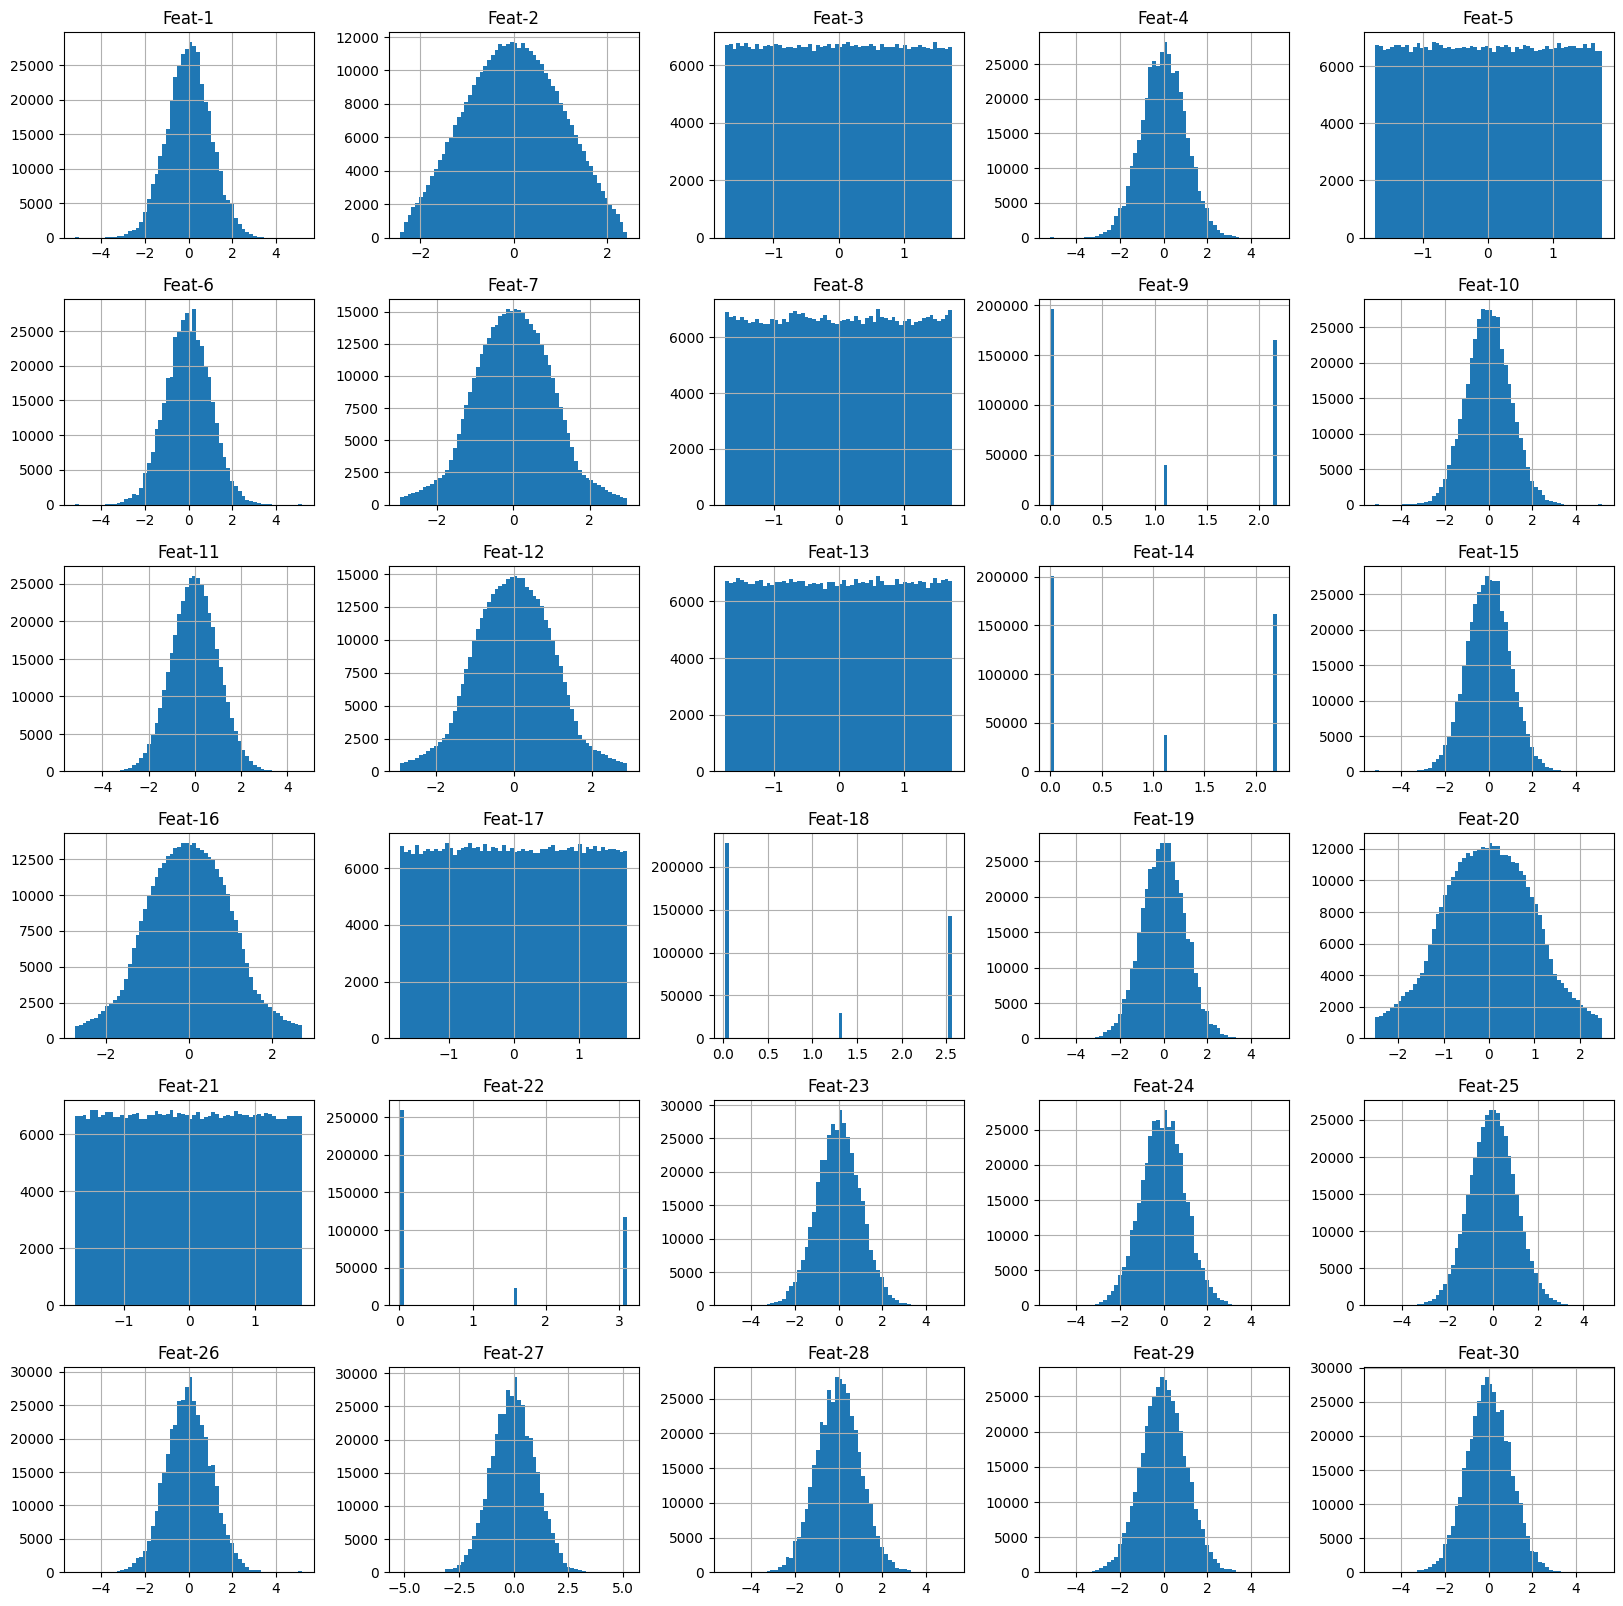

In [85]:
df.hist(figsize=(20,20), bins=60)
plt.show()

In [86]:
# split data into labels and data
data = df.to_numpy()
len(data)

400000

In [87]:
# split data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3)

In [89]:
# train a neural network using pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(30, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x
    

# create dataset and dataloader
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0") 
train_data = TensorDataset(torch.from_numpy(X_train).float().to(device), torch.from_numpy(y_train).float().to(device).reshape(-1, 1))
val_data = TensorDataset(torch.from_numpy(X_val).float().to(device), torch.from_numpy(y_val).float().to(device).reshape(-1, 1))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1024)

# train the model
net = Net()
net.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr= 5 * 1e-4)
epochs = 500

best_val_acc = 0
for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # accuracy on validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = net(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch[{epoch+1}]: Validation Accuracy: {100 * correct / total}')
    if correct / total > best_val_acc:
        best_val_acc = correct / total
        torch.save(net.state_dict(), 'model4_logs.pth')
        print('Model saved')

Epoch[1]: Validation Accuracy: 69.84666666666666
Model saved
Epoch[2]: Validation Accuracy: 70.73833333333333
Model saved
Epoch[3]: Validation Accuracy: 71.3675
Model saved
Epoch[4]: Validation Accuracy: 71.62
Model saved
Epoch[5]: Validation Accuracy: 71.71916666666667
Model saved
Epoch[6]: Validation Accuracy: 71.92666666666666
Model saved
Epoch[7]: Validation Accuracy: 71.95083333333334
Model saved
Epoch[8]: Validation Accuracy: 72.2725
Model saved
Epoch[9]: Validation Accuracy: 72.42416666666666
Model saved
Epoch[10]: Validation Accuracy: 72.3075
Epoch[11]: Validation Accuracy: 72.3375
Epoch[12]: Validation Accuracy: 72.5625
Model saved
Epoch[13]: Validation Accuracy: 72.60916666666667
Model saved
Epoch[14]: Validation Accuracy: 72.5975
Epoch[15]: Validation Accuracy: 72.67083333333333
Model saved
Epoch[16]: Validation Accuracy: 72.6675
Epoch[17]: Validation Accuracy: 72.7175
Model saved
Epoch[18]: Validation Accuracy: 72.71
Epoch[19]: Validation Accuracy: 72.845
Model saved
Epoch[

KeyboardInterrupt: 

In [ ]:
#training accuracy
clf.score(X_train, y_train)

In [ ]:
# validation accuracy
clf.score(X_val, y_val)

In [112]:
test_df = pd.read_csv('test.csv')
test_df = test_df.drop(columns=['ID'])
test_df.head()

,Feat-1,Feat-2,Feat-3,Feat-4,Feat-5,Feat-6,Feat-7,Feat-8,Feat-9,Feat-10,...,Feat-21,Feat-22,Feat-23,Feat-24,Feat-25,Feat-26,Feat-27,Feat-28,Feat-29,Feat-30
0,0.705412,-0.271127,-0.157189,0.799714,0.514731,1.353042,0.195482,-0.101601,-0.001558,0.897195,...,1.552919,0.009059,0.973914,1.387095,-0.268359,0.994046,1.053863,0.851101,1.081227,0.910638
1,0.769831,-1.291846,1.730552,0.739716,-1.021147,0.632643,0.762884,0.358634,2.171518,0.551590,...,0.675603,1.560039,0.700915,0.816112,-1.890694,1.002816,0.754517,0.269195,0.761649,0.741299
2,0.346531,-1.053224,-0.169951,2.650206,-1.336002,0.806697,0.541072,0.255520,2.171518,0.519485,...,1.268804,0.009059,0.786138,0.661605,0.641856,1.186704,0.838251,0.812189,1.133564,0.923557
3,1.341917,-0.781487,0.427182,1.626247,1.200557,1.366600,-1.224508,-1.025747,1.084980,0.983817,...,1.178353,0.009059,0.766933,1.059928,-0.827337,1.318583,1.663129,1.061580,1.125837,1.055879
4,1.056240,0.217805,1.333826,1.166646,-1.327727,2.793108,0.144980,1.574933,2.171518,3.829739,...,-0.488150,0.009059,0.445712,0.914705,0.246885,1.051196,0.907779,2.678149,2.306476,1.795715


In [113]:
test_df[skewed_features] = qt.fit_transform(test_df[skewed_features])
test_data = scaler.transform(test_df)

In [114]:
# generate predictions.csv by loading model from .pth file, one column is ID other column is Target, 1 indexed
submission_net = Net().to(device)
submission_net.load_state_dict(torch.load('model4_logs.pth'))
submission_net.eval()

test_x_torch = torch.from_numpy(test_data).float().to(device)
submission = submission_net(test_x_torch).detach().cpu().numpy()
submission = submission.reshape(-1)
submission = submission > 0.5
submission = submission.astype(int)

submission_df = pd.DataFrame({'ID': np.arange(1, len(submission) + 1), 'Target': submission})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
# output to csv with ID(1-indexed) and Target columns
df = pd.DataFrame({'ID': np.arange(1, len(output)+1), 'Target': output})
df.to_csv('predictions.csv', index=False)